# Delayed starts


In many applications, it is needed to 'delay' the start of particle advection. For example because particles need to be released at different times throughout an experiment. Or because particles need to be released at a constant rate from the same set of locations.

This tutorial will show how this can be done. We start with importing the relevant modules.


In [1]:
from datetime import timedelta

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from IPython.display import HTML
from matplotlib.animation import FuncAnimation

import parcels

First import a `FieldSet` (from the Peninsula example, in this case)


In [2]:
example_dataset_folder = parcels.download_example_dataset("Peninsula_data")
fieldset = parcels.FieldSet.from_parcels(
    f"{example_dataset_folder}/peninsula", allow_time_extrapolation=True
)

Now, there are two ways to delay the start of particles. Either by defining the whole `ParticleSet` at initialisation and giving each particle its own `time`. Or by using the `repeatdt` argument. We will show both options here


## Assigning each particle its own `time`


The simplest way to delay the start of a particle is to use the `time` argument for each particle


In [3]:
npart = 10  # number of particles to be released
lon = 3e3 * np.ones(npart)
lat = np.linspace(3e3, 45e3, npart, dtype=np.float32)

# release every particle one hour later
time = np.arange(0, npart) * timedelta(hours=1).total_seconds()

pset = parcels.ParticleSet(
    fieldset=fieldset, pclass=parcels.JITParticle, lon=lon, lat=lat, time=time
)

Then we can execute the `pset` as usual


In [4]:
output_file = pset.ParticleFile(
    name="DelayParticle_time.zarr", outputdt=timedelta(hours=1)
)

pset.execute(
    parcels.AdvectionRK4,
    runtime=timedelta(hours=24),
    dt=timedelta(minutes=5),
    output_file=output_file,
)

INFO: Output files are stored in DelayParticle_time.zarr.
100%|██████████| 86400.0/86400.0 [00:02<00:00, 35968.90it/s]


And then finally, we can show a movie of the particles. Note that the southern-most particles start to move first.


In [5]:
%%capture

ds = xr.open_zarr("DelayParticle_time.zarr")

fig = plt.figure(figsize=(7, 5), constrained_layout=True)
ax = fig.add_subplot()

ax.set_ylabel("Meridional distance [m]")
ax.set_xlabel("Zonal distance [m]")
ax.set_xlim(0, 9e4)
ax.set_ylim(0, 5e4)

timerange = np.unique(ds["time"].values[np.isfinite(ds["time"])])

# Indices of the data where time = 0
time_id = np.where(ds["time"] == timerange[0])

sc = ax.scatter(ds["lon"].values[time_id], ds["lat"].values[time_id])

t = str(timerange[0].astype("timedelta64[h]"))
title = ax.set_title(f"Particles at t = {t}")


def animate(i):
    t = str(timerange[i].astype("timedelta64[h]"))
    title.set_text(f"Particles at t = {t}")

    time_id = np.where(ds["time"] == timerange[i])
    sc.set_offsets(np.c_[ds["lon"].values[time_id], ds["lat"].values[time_id]])


anim = FuncAnimation(fig, animate, frames=len(timerange), interval=100)

In [6]:
HTML(anim.to_jshtml())

## Using the `repeatdt` argument


The second method to delay the start of particle releases is to use the `repeatdt` argument when constructing a `ParticleSet`. This is especially useful if you want to repeatedly release particles from the same set of locations.


In [7]:
npart = 10  # number of particles to be released
lon = 3e3 * np.ones(npart)
lat = np.linspace(3e3, 45e3, npart, dtype=np.float32)
repeatdt = timedelta(hours=3)  # release from the same set of locations every 3h

pset = parcels.ParticleSet(
    fieldset=fieldset, pclass=parcels.JITParticle, lon=lon, lat=lat, repeatdt=repeatdt
)

Now we again define an output file and execute the `pset` as usual.


In [8]:
output_file = pset.ParticleFile(
    name="DelayParticle_releasedt", outputdt=timedelta(hours=1)
)

pset.execute(
    parcels.AdvectionRK4,
    runtime=timedelta(hours=24),
    dt=timedelta(minutes=5),
    output_file=output_file,
)

INFO: Output files are stored in DelayParticle_releasedt.zarr.
  0%|          | 0/86400.0 [00:00<?, ?it/s]WARNING: ParticleFile chunks are set to (10, 1), but this may lead to a significant slowdown in Parcels when many calls to repeatdt. Consider setting a larger chunk size for your ParticleFile (e.g. chunks=(int(1e4), 1)).
100%|██████████| 86400.0/86400.0 [00:01<00:00, 49894.21it/s]


And we get an animation where a new particle is released every 3 hours from each start location


In [9]:
%%capture

ds = xr.open_zarr("DelayParticle_releasedt.zarr")

fig = plt.figure(figsize=(7, 5), constrained_layout=True)
ax = fig.add_subplot()

ax.set_ylabel("Meridional distance [m]")
ax.set_xlabel("Zonal distance [m]")
ax.set_xlim(0, 9e4)
ax.set_ylim(0, 5e4)

timerange = np.unique(ds["time"].values[np.isfinite(ds["time"])])

# Indices of the data where time = 0
time_id = np.where(ds["time"] == timerange[0])

sc = ax.scatter(ds["lon"].values[time_id], ds["lat"].values[time_id])

t = str(timerange[0].astype("timedelta64[h]"))
title = ax.set_title(f"Particles at t = {t}")


def animate(i):
    t = str(timerange[i].astype("timedelta64[h]"))
    title.set_text(f"Particles at t = {t}")

    time_id = np.where(ds["time"] == timerange[i])
    sc.set_offsets(np.c_[ds["lon"].values[time_id], ds["lat"].values[time_id]])


anim = FuncAnimation(fig, animate, frames=len(timerange), interval=100)

In [10]:
HTML(anim.to_jshtml())

Note that, if you want to if you want to at some point stop the repeatdt, the easiest implementation is to use two calls to `pset.execute()`. For example, if in the above example you only want four releases of the pset, you could do the following


In [11]:
pset = parcels.ParticleSet(
    fieldset=fieldset, pclass=parcels.JITParticle, lon=lon, lat=lat, repeatdt=repeatdt
)
output_file = pset.ParticleFile(
    name="DelayParticle_releasedt_9hrs", outputdt=timedelta(hours=1)
)

# first run for 3 * 3 hrs
pset.execute(
    parcels.AdvectionRK4,
    runtime=timedelta(hours=9),
    dt=timedelta(minutes=5),
    output_file=output_file,
)

# now stop the repeated release
pset.repeatdt = None

# now continue running for the remaining 15 hours
pset.execute(
    parcels.AdvectionRK4,
    runtime=timedelta(hours=15),
    dt=timedelta(minutes=5),
    output_file=output_file,
)

INFO: Output files are stored in DelayParticle_releasedt_9hrs.zarr.
  0%|          | 0/32400.0 [00:00<?, ?it/s]WARNING: ParticleFile chunks are set to (10, 1), but this may lead to a significant slowdown in Parcels when many calls to repeatdt. Consider setting a larger chunk size for your ParticleFile (e.g. chunks=(int(1e4), 1)).
100%|██████████| 32400.0/32400.0 [00:00<00:00, 82972.21it/s]
INFO: Output files are stored in DelayParticle_releasedt_9hrs.zarr.
100%|██████████| 54000.0/54000.0 [00:00<00:00, 76251.78it/s]


In [12]:
%%capture

ds = xr.open_zarr("DelayParticle_releasedt_9hrs.zarr")

fig = plt.figure(figsize=(7, 5), constrained_layout=True)
ax = fig.add_subplot()

ax.set_ylabel("Meridional distance [m]")
ax.set_xlabel("Zonal distance [m]")
ax.set_xlim(0, 9e4)
ax.set_ylim(0, 5e4)

timerange = np.unique(ds["time"].values[np.isfinite(ds["time"])])

# Indices of the data where time = 0
time_id = np.where(ds["time"] == timerange[0])

sc = ax.scatter(ds["lon"].values[time_id], ds["lat"].values[time_id])

t = str(timerange[0].astype("timedelta64[h]"))
title = ax.set_title(f"Particles at t = {t}")


def animate(i):
    t = str(timerange[i].astype("timedelta64[h]"))
    title.set_text(f"Particles at t = {t}")

    time_id = np.where(ds["time"] == timerange[i])
    sc.set_offsets(np.c_[ds["lon"].values[time_id], ds["lat"].values[time_id]])


anim = FuncAnimation(fig, animate, frames=len(timerange), interval=100)

In [13]:
HTML(anim.to_jshtml())

## Synced `time` in the output file

Note that, because the `outputdt` variable controls the JIT-loop, all particles are written _at the same time_, even when they start at a non-multiple of `outputdt`.

For example, if your particles start at `time=[0, 1, 2]` and `outputdt=2`, then the times written (for `dt=1` and `endtime=4`) will be


In [14]:
outtime_expected = np.array(
    [[0, 2, 4], [2, 4, np.datetime64("NaT")], [2, 4, np.datetime64("NaT")]],
    dtype="timedelta64[s]",
)
print(outtime_expected)

[[    0     2     4]
 [    2     4 'NaT']
 [    2     4 'NaT']]


In [15]:
outfilepath = "DelayParticle_nonmatchingtime.zarr"

pset = parcels.ParticleSet(
    fieldset=fieldset,
    pclass=parcels.JITParticle,
    lat=[3e3] * 3,
    lon=[3e3] * 3,
    time=[0, 1, 2],
)

output_file = pset.ParticleFile(name=outfilepath, outputdt=2)
pset.execute(
    parcels.AdvectionRK4,
    endtime=4,
    dt=1,
    output_file=output_file,
)

# Note that we also need to write the final time to the file
output_file.write_latest_locations(pset, 4)

INFO: Output files are stored in DelayParticle_nonmatchingtime.zarr.
100%|██████████| 4.0/4.0 [00:00<00:00, 57.38it/s]


And indeed, the `time` values in the NetCDF output file are as expected


In [16]:
outtime_infile = xr.open_zarr(outfilepath).time.values[:]
print(outtime_infile.astype("timedelta64[s]"))

assert (
    outtime_expected[np.isfinite(outtime_expected)]
    == outtime_infile[np.isfinite(outtime_infile)]
).all()

[[    0     2     4]
 [    2     4 'NaT']
 [    2     4 'NaT']]


Now, for some applications, this behavior may be undesirable; for example when particles need to be analyzed at a same age (instead of at a same time). In that case, we recommend either changing `outputdt` so that it is a common divisor of all start times; or doing multiple Parcels runs with subsets of the original `ParticleSet` (e.g., in the example above, one run with the Particles that start at `time=[0, 2]` and one with the Particle at `time=[1]`). In that case, you will get two files:


In [17]:
for times in [[0, 2], [1]]:
    pset = parcels.ParticleSet(
        fieldset=fieldset,
        pclass=parcels.JITParticle,
        lat=[3e3] * len(times),
        lon=[3e3] * len(times),
        time=times,
    )
    output_file = pset.ParticleFile(name=outfilepath, outputdt=2)
    pset.execute(
        parcels.AdvectionRK4,
        endtime=4,
        dt=1,
        output_file=output_file,
    )
    # Note that we also need to write the final time to the file
    output_file.write_latest_locations(pset, 4)
    print(xr.open_zarr(outfilepath).time.values[:].astype("timedelta64[s]"))

INFO: Output files are stored in DelayParticle_nonmatchingtime.zarr.
100%|██████████| 4.0/4.0 [00:00<00:00, 65.51it/s]
[[    0     2     4]
 [    2     4 'NaT']]
INFO: Output files are stored in DelayParticle_nonmatchingtime.zarr.
100%|██████████| 3.0/3.0 [00:00<00:00, 95.96it/s]
[[1 3 4]]


## Adding new particles to a ParticleSet during runtime


In the examples above, all particles were defined at the start of the simulation. There are use-cases, though, where it is important to be able to add particles 'on-the-fly', during the runtime of a Parcels simulation.

Unfortuantely, Parcels does not (yet) support adding new particles _within_ a `Kernel`. A workaround is to temporarily leave the `execution()` call to add particles via the `ParticleSet.add()` method, before continuing with `execution()`.

See the example below, where we add 'mass' to a particle each timestep, based on a probablistic condition, and then split the particle once its 'mass' is larger than 5


In [18]:
GrowingParticle = parcels.JITParticle.add_variables(
    [
        parcels.Variable("mass", initial=0),
        parcels.Variable("splittime", initial=-1),
        parcels.Variable("splitmass", initial=0),
    ]
)


def GrowParticles(particle, fieldset, time):
    # 25% chance per timestep for particle to grow
    if ParcelsRandom.random() < 0.25:
        particle.mass += 1.0
    if (particle.mass >= 5.0) and (particle.splittime < 0):
        particle.splittime = time
        particle.splitmass = particle.mass / 2.0
        particle.mass = particle.mass / 2.0


pset = parcels.ParticleSet(fieldset=fieldset, pclass=GrowingParticle, lon=0, lat=0)
outfile = parcels.ParticleFile("growingparticles.zarr", pset, outputdt=1)

for t in range(40):
    pset.execute(
        GrowParticles, runtime=1, dt=1, output_file=outfile, verbose_progress=False
    )
    for p in pset:
        if p.splittime > 0:
            pset.add(
                parcels.ParticleSet(
                    fieldset=fieldset,
                    pclass=GrowingParticle,
                    lon=0,
                    lat=0,
                    time=p.splittime,
                    mass=p.splitmass,
                )
            )
            p.splittime = -1  # reset splittime

INFO: Output files are stored in growingparticles.zarr.
INFO: Output files are stored in growingparticles.zarr.
INFO: Output files are stored in growingparticles.zarr.
INFO: Output files are stored in growingparticles.zarr.
INFO: Output files are stored in growingparticles.zarr.
INFO: Output files are stored in growingparticles.zarr.
INFO: Output files are stored in growingparticles.zarr.
INFO: Output files are stored in growingparticles.zarr.
INFO: Output files are stored in growingparticles.zarr.
INFO: Output files are stored in growingparticles.zarr.
INFO: Output files are stored in growingparticles.zarr.
INFO: Output files are stored in growingparticles.zarr.
INFO: Output files are stored in growingparticles.zarr.
INFO: Output files are stored in growingparticles.zarr.
INFO: Output files are stored in growingparticles.zarr.
INFO: Output files are stored in growingparticles.zarr.
INFO: Output files are stored in growingparticles.zarr.
INFO: Output files are stored in growingparticle

The 'trick' is that we place the `pset.execute()` call in a for-loop, so that we leave the JIT-mode and can add Particles to the ParticleSet.

Indeed, if we plot the mass of particles as a function of time, we see that new particles are created every time a particle reaches a mass of 5.


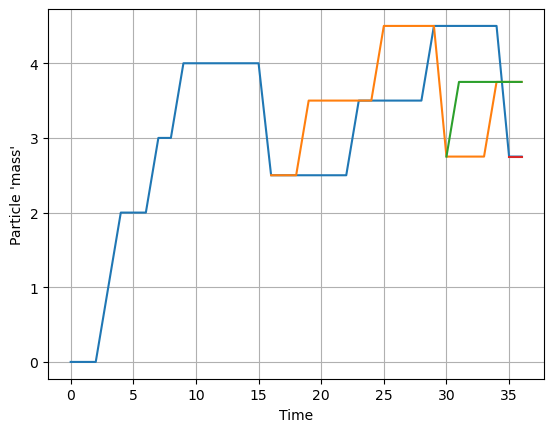

In [19]:
ds = xr.open_zarr("growingparticles.zarr")
plt.plot(ds.time.values[:].astype("timedelta64[s]").T, ds.mass.T)
plt.grid()
plt.xlabel("Time")
plt.ylabel("Particle 'mass'")
plt.show()